This notebook was created at 19:02 06/10/20

LeNet-5 inspired CCN architecture applied to classification of simulated isotropic and liquid crystal (LC) textures

This notebook is meant as an initial proof-of-concept for the overall aim of classifying LC phases from textures. This proof-of-concept will be to test the binary classification of textures representing isotopic and non-isotropic (LC) phases. These textures will be simulated, generating the data. 

Isotropic is represented as a completely black image. This is the texture obtained for an isotropic phase using the method of polarizing microscopy. The LC phase will be represented by textures that aren't completely black.

Specifically this classification will be implemented using a simple convolutional network (CNN) - LeNet-5 inspired - as this is a CNN that is not to computationally expensive for this task, but should be applicable when generalising the classification to multiple textures.

We'll be using keras and/or tensorflow.

In [1]:
pip install tensorflow keras numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras.backend as K

Define the function for generating the simulated texture images. The images will be 32x32 (a choice made so that the size matches the size that LeNet-5 was designed for).

In [3]:
def random_image_and_labels_generator(image_shape, N):
    """
    Generates random images and their corresponding labels
    (1 for bright/LC)

    Parameters
    ----------
    image_shape : tuple
        Shape of images we want to generate
    N : int
        number of images we want to generate

    Returns
    -------
    images : np.array
        Generated images together in an array of size (N, image height, image width, 1)
    labels : np.array
        The corresponding labels for the generated images of shape (N, 1)

    """
    # Add the images to an array
    images = np.zeros((1, image_shape[0], image_shape[1], 1)) # we'll need to remove this entry of zeros
    
    for i in range(N):
        # Generate image of size image_size with random
        # pixel values between 0 and 1 (representing a random
        # normalized image)
        image = np.random.rand(1, image_shape[0], image_shape[1], 1) # size (pixels, pixels)
        images = np.concatenate((images, image), axis = 0) # will be size (N, pixels, pixels)
    
    images = np.delete(images, 0, axis = 0)
    # Generate labels, 1
    labels = np.zeros((N, 1)) + 1
    
    return images, labels

In [4]:
def generate_data(image_shape, N_examples):
    """
    Generate the data for this classification problem

    Parameters
    ----------
    image_shape : tuple
        Shape of images we're dealing with
    N_examples : int
        Number of examples we're generating for the dataset

    Returns
    -------
    images_shuffled : np.array
        Shuffled images that were generated of size (N_examples, image height, image width, 1)
    labels_shuffled : np.array
        Labels corresponding to the shuffled images, 1 for LC and 0 for isotropic, of size (N_examples, 1)

    """
    # Want a balanced data set - half iso, half LC
    N = int(N_examples/2) # Won't work properly for odd values of N_examples right now

    # Generate LC images and labels (1 for LC image)
    images_LC, labels_LC = random_image_and_labels_generator(image_shape, N)
    
    # Generate isotropic images and labels (0 for
    # isotropic image) by adding zeros to dataset
    images_iso = np.zeros((N, image_shape[0], image_shape[1], 1))
    labels_iso = np.zeros((N, 1))
    
    # Combine into one dataset
    images_ordered = np.concatenate((images_LC, images_iso), axis = 0)
    labels_ordered = np.concatenate((labels_LC, labels_iso), axis = 0)

    # randomly shuffle the LC and iso images and labels
    images_shuffled, labels_shuffled = shuffle(images_ordered, labels_ordered)
    
    return images_shuffled, labels_shuffled

Generate some data.

In [5]:
image_shape = (32,32)
N_examples = 1000
images, labels = generate_data(image_shape, N_examples)

Let's look at some of the images and make sure the labels are matching up.

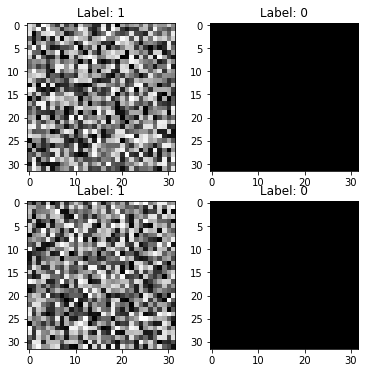

In [6]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%labels[i])
    plt.imshow(images[i,:,:].reshape([32,32]),cmap='gray')

Now we'll split the data into train and test sets.

In [7]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.33)

print ("number of training examples = " + str(images_train.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("X_train shape: " + str(images_train.shape))
print ("Y_train shape: " + str(labels_train.shape))
print ("X_test shape: " + str(images_test.shape))
print ("Y_test shape: " + str(labels_test.shape))

number of training examples = 670
number of test examples = 330
X_train shape: (670, 32, 32, 1)
Y_train shape: (670, 1)
X_test shape: (330, 32, 32, 1)
Y_test shape: (330, 1)


Define the LeNet-5 model.

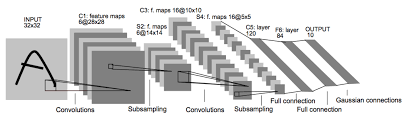

In [29]:
def leNet5(input_shape):
    """
    Create an instance of model class representing LeNet-5
    inspired architecture

    Parameters
    ----------
    input_shape : tuple
        shape to be input to the CNN

    Returns
    -------
    model : instance of model class
        our LeNet-5 inspired model

    """
    # Input placeholder with shape input_shape
    X_input = Input(input_shape)
    
    # Apply 6 5x5 filter convolution with stride of 1
    X = Conv2D(6, (5,5), strides = (1,1), activation = "relu", name = "conv1")(X_input)
    # Apply maxpooling with a filter size of 2x2 and stride of 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool1")(X)
    # Apply 16 5x5 filter convolution with stride of 1
    X = Conv2D(16, (5,5), strides = (1,1), activation = "relu", name = "conv2")(X)
    # Apply maxpooling with a filter size of 2x2 and stride 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool2")(X)
    
    # Flatten X (convert to a vector) before going to fully
    # connected layers
    X = Flatten()(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(120, activation="relu", name = "fc3")(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(84, activation="relu", name = "fc5")(X)
    
    # Output a single binary classification
    X = Dense(1, activation="sigmoid", name = "fc_out")(X)
    
    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name="LeNet-5")
    
    return model

Create the model.

In [30]:
LeNet5_model = leNet5(images_train.shape[1:])

Compile the model

In [31]:
LeNet5_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Train the model

In [32]:
LeNet5_model.fit(x = images_train, y = labels_train, epochs = 5, batch_size = 64)

Epoch 1/5
11/11 [==============================] - 0s 9ms/step - loss: 0.4705 - accuracy: 0.7507
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.3345 - accuracy: 1.0000
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.3235 - accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.3039 - accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 0s 8ms/step - loss: 0.2564 - accuracy: 1.0000


Get predictions on the test set.

In [33]:
test = LeNet5_model.evaluate(x = images_test, y = labels_test)
print()
print("Test accuracy = " + str(test[1]))

11/11 [==============================] - 0s 3ms/step - loss: 0.2104 - accuracy: 1.0000

Test accuracy = 1.0


It seems that this CNN was overkill for this task, maybe a simple logistic regression binary classification would suffice.

In [34]:
prediction = LeNet5_model.predict(images_test)

Label: 1
Prediction: 1


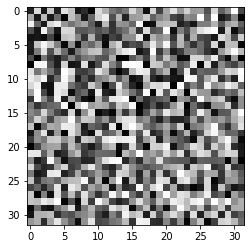

In [35]:
plt.imshow(images_test[75,:,:,].reshape(32,32), cmap="gray")
print("Label: %i"%labels_test[75])
print("Prediction: %i"%prediction[75])

In [36]:
print(prediction.shape)
print(labels_test.shape)

(330, 1)
(330, 1)


In [38]:
for i in range(len(prediction)):
    if prediction[i] == 1:
        print("Predicted that " + str(i) + " was a LC.")
        
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(str(i) + " actually was a LC.")

Predicted that 2 was a LC.
Predicted that 3 was a LC.
Predicted that 5 was a LC.
Predicted that 9 was a LC.
Predicted that 10 was a LC.
Predicted that 11 was a LC.
Predicted that 13 was a LC.
Predicted that 14 was a LC.
Predicted that 17 was a LC.
Predicted that 19 was a LC.
Predicted that 20 was a LC.
Predicted that 21 was a LC.
Predicted that 22 was a LC.
Predicted that 23 was a LC.
Predicted that 24 was a LC.
Predicted that 25 was a LC.
Predicted that 27 was a LC.
Predicted that 29 was a LC.
Predicted that 32 was a LC.
Predicted that 33 was a LC.
Predicted that 35 was a LC.
Predicted that 38 was a LC.
Predicted that 39 was a LC.
Predicted that 42 was a LC.
Predicted that 44 was a LC.
Predicted that 50 was a LC.
Predicted that 51 was a LC.
Predicted that 55 was a LC.
Predicted that 57 was a LC.
Predicted that 59 was a LC.
Predicted that 60 was a LC.
Predicted that 61 was a LC.
Predicted that 63 was a LC.
Predicted that 65 was a LC.
Predicted that 66 was a LC.
Predicted that 68 was a 